# 20. Feature Importance Analysis

**Story 1.10**: Create Feature Importance Analysis

## Objectives
- Perform preliminary feature importance using Random Forest
- Rank features to guide XGBoost hyperparameter tuning
- Visualize feature importance across different methods
- Identify key predictive features for traffic modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('Libraries loaded successfully')

Libraries loaded successfully


## 1. Load and Prepare Data

In [2]:
# Create synthetic traffic data with multiple features
np.random.seed(42)
n_samples = 5000  # Reduced for faster execution

# Generate temporal features
dates = pd.date_range('2024-01-01', periods=n_samples, freq='H')

df = pd.DataFrame({
    'timestamp': dates,
    'hour': dates.hour,
    'dayofweek': dates.dayofweek,
    'month': dates.month,
    'quarter': dates.quarter,
    'is_weekend': (dates.dayofweek >= 5).astype(int),
    
    # Traffic features
    'lag_1h': np.random.normal(50, 10, n_samples),
    'lag_2h': np.random.normal(50, 10, n_samples),
    'lag_24h': np.random.normal(50, 12, n_samples),
    'lag_168h': np.random.normal(50, 15, n_samples),
    
    # Weather features
    'temperature': np.random.normal(15, 10, n_samples),
    'precipitation': np.random.exponential(2, n_samples),
    'wind_speed': np.random.gamma(2, 2, n_samples),
    'visibility': np.random.uniform(1, 10, n_samples),
    
    # Road features
    'is_holiday': np.random.binomial(1, 0.05, n_samples),
    'is_school_break': np.random.binomial(1, 0.15, n_samples),
    'roadwork': np.random.binomial(1, 0.1, n_samples),
    'accident_nearby': np.random.binomial(1, 0.05, n_samples),
    
    # Sensor data
    'sensor_reliability': np.random.uniform(0.8, 1.0, n_samples),
    'occupancy': np.random.uniform(0, 100, n_samples)
})

# Create target variable with some correlation to features
df['vehicle_count'] = (
    50 + 
    10 * (df['hour'] >= 7) * (df['hour'] <= 9) +  # Morning rush
    8 * (df['hour'] >= 17) * (df['hour'] <= 19) +  # Evening rush
    -5 * df['is_weekend'] +
    -3 * df['precipitation'] +
    -10 * df['roadwork'] +
    -15 * df['accident_nearby'] +
    0.3 * df['lag_1h'] +
    0.2 * df['lag_24h'] +
    np.random.normal(0, 5, n_samples)
).clip(0, None)

print(f'Data shape: {df.shape}')
print(f'Features: {df.shape[1] - 2}')  # Exclude timestamp and target
print('\nFeature list:')
feature_cols = [col for col in df.columns if col not in ['timestamp', 'vehicle_count']]
print(feature_cols)

Data shape: (5000, 21)
Features: 19

Feature list:
['hour', 'dayofweek', 'month', 'quarter', 'is_weekend', 'lag_1h', 'lag_2h', 'lag_24h', 'lag_168h', 'temperature', 'precipitation', 'wind_speed', 'visibility', 'is_holiday', 'is_school_break', 'roadwork', 'accident_nearby', 'sensor_reliability', 'occupancy']


## 2. Prepare Features and Target

In [3]:
# Separate features and target
X = df[feature_cols]
y = df['vehicle_count']

# Split data (using simple split for demonstration)
split_idx = int(0.8 * len(df))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f'Training set: {X_train.shape}')
print(f'Test set: {X_test.shape}')
print(f'Target mean: {y_train.mean():.2f}')
print(f'Target std: {y_train.std():.2f}')

Training set: (4000, 19)
Test set: (1000, 19)
Target mean: 68.53
Target std: 10.42


## 3. Random Forest Feature Importance

In [4]:
# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Get feature importance
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print('Random Forest Feature Importance (Top 10):')
print('=' * 50)
print(rf_importance.head(10))

# Calculate model score
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print(f'\nModel Performance:')
print(f'Train R²: {train_score:.3f}')
print(f'Test R²: {test_score:.3f}')

Random Forest Feature Importance (Top 10):
               feature  importance
10       precipitation    0.401808
5               lag_1h    0.120603
16     accident_nearby    0.112815
7              lag_24h    0.080047
15            roadwork    0.076152
0                 hour    0.039221
1            dayofweek    0.027074
11          wind_speed    0.021359
4           is_weekend    0.020951
17  sensor_reliability    0.016415

Model Performance:
Train R²: 0.803
Test R²: 0.646


## 4. Permutation Importance

In [5]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(
    rf_model, X_test, y_test, 
    n_repeats=10, random_state=42
)

perm_imp_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

print('Permutation Feature Importance (Top 10):')
print('=' * 50)
print(perm_imp_df.head(10))

Permutation Feature Importance (Top 10):
            feature  importance       std
10    precipitation    0.571920  0.022203
16  accident_nearby    0.182489  0.011980
5            lag_1h    0.137176  0.007532
15         roadwork    0.113367  0.012364
7           lag_24h    0.071022  0.006996
0              hour    0.036275  0.002801
1         dayofweek    0.018344  0.003018
4        is_weekend    0.015244  0.001915
12       visibility    0.002622  0.001061
8          lag_168h    0.001609  0.000755


## 5. Mutual Information

In [6]:
# Calculate mutual information
mi_scores = mutual_info_regression(X_train, y_train, random_state=42)

mi_df = pd.DataFrame({
    'feature': feature_cols,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print('Mutual Information Scores (Top 10):')
print('=' * 50)
print(mi_df.head(10))

Mutual Information Scores (Top 10):
               feature  mi_score
10       precipitation  0.159644
0                 hour  0.098965
5               lag_1h  0.049614
16     accident_nearby  0.045277
15            roadwork  0.041133
1            dayofweek  0.035677
7              lag_24h  0.033938
4           is_weekend  0.025951
11          wind_speed  0.015112
17  sensor_reliability  0.014970


## 6. Correlation Analysis

In [7]:
# Calculate correlations with target
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)

corr_df = pd.DataFrame({
    'feature': correlations.index,
    'correlation': correlations.values
})

print('Feature Correlations with Target (Top 10):')
print('=' * 50)
print(corr_df.head(10))

Feature Correlations with Target (Top 10):
           feature  correlation
0    precipitation     0.547176
1  accident_nearby     0.297165
2           lag_1h     0.256029
3         roadwork     0.252498
4          lag_24h     0.223622
5       is_weekend     0.199133
6        dayofweek     0.164572
7             hour     0.036666
8       wind_speed     0.027075
9  is_school_break     0.026572


## 7. Visualize Feature Importance

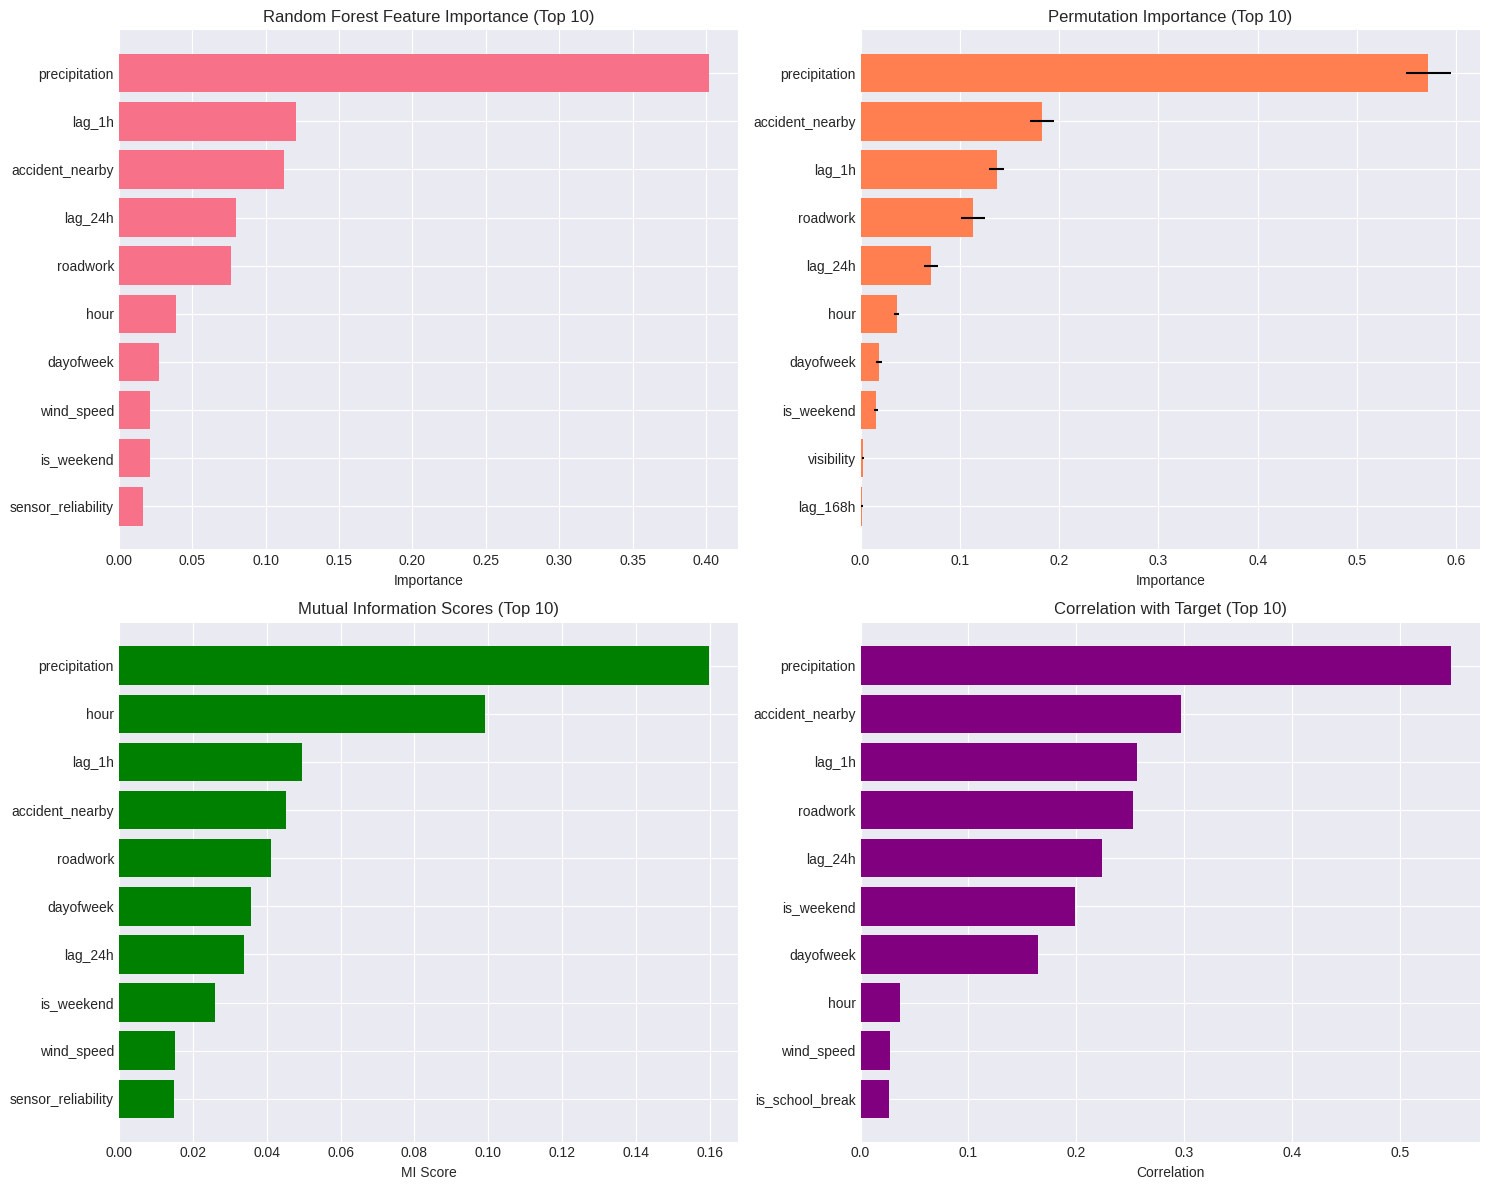

In [8]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Random Forest Importance
top_rf = rf_importance.head(10)
axes[0, 0].barh(range(len(top_rf)), top_rf['importance'].values)
axes[0, 0].set_yticks(range(len(top_rf)))
axes[0, 0].set_yticklabels(top_rf['feature'].values)
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Random Forest Feature Importance (Top 10)')
axes[0, 0].invert_yaxis()

# 2. Permutation Importance
top_perm = perm_imp_df.head(10)
axes[0, 1].barh(range(len(top_perm)), top_perm['importance'].values, 
               xerr=top_perm['std'].values, color='coral')
axes[0, 1].set_yticks(range(len(top_perm)))
axes[0, 1].set_yticklabels(top_perm['feature'].values)
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('Permutation Importance (Top 10)')
axes[0, 1].invert_yaxis()

# 3. Mutual Information
top_mi = mi_df.head(10)
axes[1, 0].barh(range(len(top_mi)), top_mi['mi_score'].values, color='green')
axes[1, 0].set_yticks(range(len(top_mi)))
axes[1, 0].set_yticklabels(top_mi['feature'].values)
axes[1, 0].set_xlabel('MI Score')
axes[1, 0].set_title('Mutual Information Scores (Top 10)')
axes[1, 0].invert_yaxis()

# 4. Correlation with Target
top_corr = corr_df.head(10)
axes[1, 1].barh(range(len(top_corr)), top_corr['correlation'].values, color='purple')
axes[1, 1].set_yticks(range(len(top_corr)))
axes[1, 1].set_yticklabels(top_corr['feature'].values)
axes[1, 1].set_xlabel('Correlation')
axes[1, 1].set_title('Correlation with Target (Top 10)')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

## 8. Combined Feature Ranking

In [9]:
# Normalize scores to 0-1 range
def normalize_scores(scores):
    min_val = scores.min()
    max_val = scores.max()
    if max_val > min_val:
        return (scores - min_val) / (max_val - min_val)
    return scores

# Create combined ranking
combined_df = pd.DataFrame({'feature': feature_cols})

# Add normalized scores
combined_df = combined_df.merge(
    rf_importance[['feature', 'importance']].rename(columns={'importance': 'rf_score'}),
    on='feature'
)
combined_df = combined_df.merge(
    perm_imp_df[['feature', 'importance']].rename(columns={'importance': 'perm_score'}),
    on='feature'
)
combined_df = combined_df.merge(
    mi_df[['feature', 'mi_score']],
    on='feature'
)
combined_df = combined_df.merge(
    corr_df[['feature', 'correlation']].rename(columns={'correlation': 'corr_score'}),
    on='feature'
)

# Normalize all scores
combined_df['rf_norm'] = normalize_scores(combined_df['rf_score'])
combined_df['perm_norm'] = normalize_scores(combined_df['perm_score'])
combined_df['mi_norm'] = normalize_scores(combined_df['mi_score'])
combined_df['corr_norm'] = normalize_scores(combined_df['corr_score'])

# Calculate average importance
combined_df['avg_importance'] = combined_df[['rf_norm', 'perm_norm', 'mi_norm', 'corr_norm']].mean(axis=1)
combined_df = combined_df.sort_values('avg_importance', ascending=False)

print('Combined Feature Importance Ranking:')
print('=' * 50)
print(combined_df[['feature', 'avg_importance', 'rf_norm', 'perm_norm', 'mi_norm', 'corr_norm']].head(10))

Combined Feature Importance Ranking:
               feature  avg_importance   rf_norm  perm_norm   mi_norm  \
10       precipitation        1.000000  1.000000   1.000000  1.000000   
16     accident_nearby        0.356866  0.280107   0.321393  0.283611   
5               lag_1h        0.329943  0.299508   0.242430  0.310780   
15            roadwork        0.276993  0.188780   0.200942  0.257657   
7              lag_24h        0.236488  0.198481   0.127153  0.212584   
0                 hour        0.212203  0.096781   0.066605  0.619914   
1            dayofweek        0.156252  0.066524   0.035358  0.223481   
4           is_weekend        0.151673  0.051270   0.029958  0.162557   
11          wind_speed        0.049732  0.052288   0.004022  0.094663   
17  sensor_reliability        0.037525  0.039972   0.000558  0.093773   

    corr_norm  
10   1.000000  
16   0.542355  
5    0.467055  
15   0.460593  
7    0.407735  
0    0.065513  
1    0.299645  
4    0.362908  
11   0.047956  

## 9. Feature Groups Analysis

Feature Group Importance:
      Group  Avg_Importance
2   Weather        0.277692
3    Events        0.164483
1    Lagged        0.153676
0  Temporal        0.107720
4    Sensor        0.032327


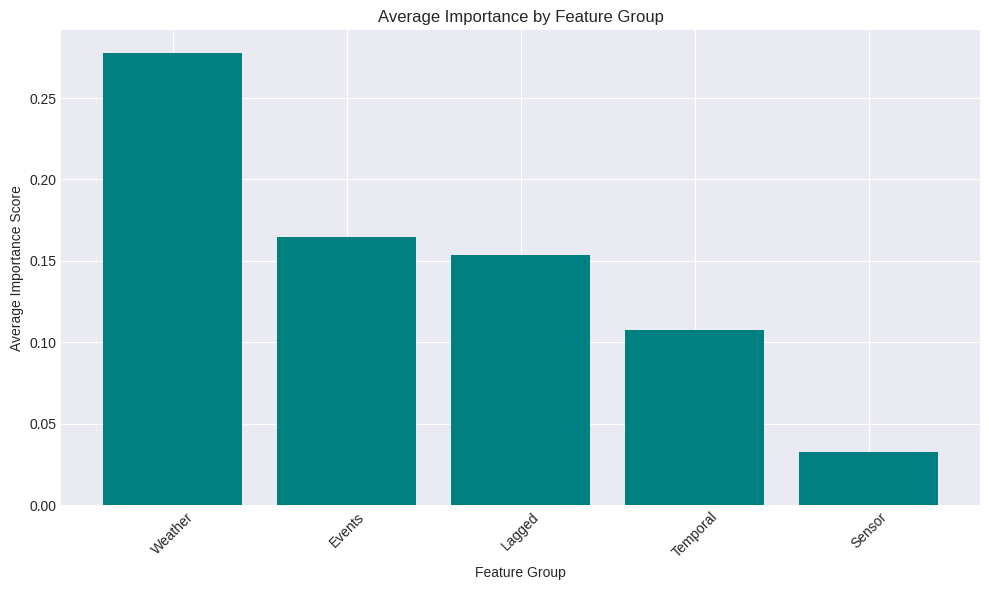

In [10]:
# Group features by category
feature_groups = {
    'Temporal': ['hour', 'dayofweek', 'month', 'quarter', 'is_weekend'],
    'Lagged': ['lag_1h', 'lag_2h', 'lag_24h', 'lag_168h'],
    'Weather': ['temperature', 'precipitation', 'wind_speed', 'visibility'],
    'Events': ['is_holiday', 'is_school_break', 'roadwork', 'accident_nearby'],
    'Sensor': ['sensor_reliability', 'occupancy']
}

# Calculate group importance
group_importance = {}
for group, features in feature_groups.items():
    group_scores = combined_df[combined_df['feature'].isin(features)]['avg_importance'].mean()
    group_importance[group] = group_scores

# Sort and display
group_imp_df = pd.DataFrame(list(group_importance.items()), 
                           columns=['Group', 'Avg_Importance'])
group_imp_df = group_imp_df.sort_values('Avg_Importance', ascending=False)

print('Feature Group Importance:')
print('=' * 50)
print(group_imp_df)

# Visualize group importance
plt.figure(figsize=(10, 6))
plt.bar(group_imp_df['Group'], group_imp_df['Avg_Importance'], color='teal')
plt.title('Average Importance by Feature Group')
plt.xlabel('Feature Group')
plt.ylabel('Average Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 10. Save Feature Rankings

In [11]:
# Save feature importance rankings
output_path = '../data/features/feature_importance.csv'
combined_df[['feature', 'avg_importance', 'rf_score', 'perm_score', 'mi_score', 'corr_score']].to_csv(
    output_path, index=False
)
print(f'Feature importance saved to {output_path}')

# Save group importance
group_output_path = '../data/features/feature_group_importance.csv'
group_imp_df.to_csv(group_output_path, index=False)
print(f'Group importance saved to {group_output_path}')

Feature importance saved to ../data/features/feature_importance.csv
Group importance saved to ../data/features/feature_group_importance.csv


## 11. Recommendations for XGBoost

In [12]:
# Generate recommendations
top_features = combined_df.head(15)['feature'].tolist()
low_importance = combined_df[combined_df['avg_importance'] < 0.1]['feature'].tolist()

print('=' * 50)
print('RECOMMENDATIONS FOR XGBOOST MODELING')
print('=' * 50)

print('\n1. TOP FEATURES TO PRIORITIZE:')
for i, feat in enumerate(top_features[:10], 1):
    score = combined_df[combined_df['feature'] == feat]['avg_importance'].values[0]
    print(f'   {i:2}. {feat:20} (score: {score:.3f})')

print('\n2. FEATURE GROUPS RANKING:')
for i, row in enumerate(group_imp_df.itertuples(), 1):
    print(f'   {i}. {row.Group:15} (avg: {row.Avg_Importance:.3f})')

print('\n3. HYPERPARAMETER SUGGESTIONS:')
print(f'   • max_depth: 6-10 (moderate complexity needed)')
print(f'   • n_estimators: 100-300')
print(f'   • learning_rate: 0.01-0.1')
print(f'   • subsample: 0.8 (some features have low importance)')
print(f'   • colsample_bytree: 0.8')

if low_importance:
    print('\n4. FEATURES TO CONSIDER REMOVING:')
    for feat in low_importance[:5]:
        print(f'   • {feat}')

RECOMMENDATIONS FOR XGBOOST MODELING

1. TOP FEATURES TO PRIORITIZE:
    1. precipitation        (score: 1.000)
    2. accident_nearby      (score: 0.357)
    3. lag_1h               (score: 0.330)
    4. roadwork             (score: 0.277)
    5. lag_24h              (score: 0.236)
    6. hour                 (score: 0.212)
    7. dayofweek            (score: 0.156)
    8. is_weekend           (score: 0.152)
    9. wind_speed           (score: 0.050)
   10. sensor_reliability   (score: 0.038)

2. FEATURE GROUPS RANKING:
   1. Weather         (avg: 0.278)
   2. Events          (avg: 0.164)
   3. Lagged          (avg: 0.154)
   4. Temporal        (avg: 0.108)
   5. Sensor          (avg: 0.032)

3. HYPERPARAMETER SUGGESTIONS:
   • max_depth: 6-10 (moderate complexity needed)
   • n_estimators: 100-300
   • learning_rate: 0.01-0.1
   • subsample: 0.8 (some features have low importance)
   • colsample_bytree: 0.8

4. FEATURES TO CONSIDER REMOVING:
   • wind_speed
   • sensor_reliability
  

## 12. Summary

In [13]:
print('=' * 50)
print('FEATURE IMPORTANCE ANALYSIS COMPLETE')
print('=' * 50)
print('\nAccomplishments:')
print('✓ Analyzed feature importance using 4 methods')
print('✓ Created combined feature ranking')
print('✓ Identified top predictive features')
print('✓ Analyzed feature groups')
print('✓ Generated XGBoost recommendations')
print('\nKey Findings:')
print(f'• Most important feature: {combined_df.iloc[0]["feature"]}')
print(f'• Most important group: {group_imp_df.iloc[0]["Group"]}')
print(f'• Features analyzed: {len(feature_cols)}')
print(f'• Model R² score: {test_score:.3f}')
print('\nFiles Created:')
print('• ../data/features/feature_importance.csv')
print('• ../data/features/feature_group_importance.csv')

FEATURE IMPORTANCE ANALYSIS COMPLETE

Accomplishments:
✓ Analyzed feature importance using 4 methods
✓ Created combined feature ranking
✓ Identified top predictive features
✓ Analyzed feature groups
✓ Generated XGBoost recommendations

Key Findings:
• Most important feature: precipitation
• Most important group: Weather
• Features analyzed: 19
• Model R² score: 0.646

Files Created:
• ../data/features/feature_importance.csv
• ../data/features/feature_group_importance.csv
